<a href="https://colab.research.google.com/github/fabiolafaria/ET5003-Etivity/blob/main/ET5003_Etivity2_FabiolaFaria_20197799.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-10-03' #@param {type:"date"}

In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20197799" #@param {type:"string"}
Student_full_name = "Fabiola Faria" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Final' #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# INTRODUCTION

### Problem Description

The goal of this task is to use advanced Machine Learning methods to predict House price. Prediction house prices helps people to make a better decision to buy a house in a near future, people could know the price range and plan their finance well. On the other hand, house price predictions could help to property investors by knowing the trend of housing prices in different locations.
We will also utilise piecewise regression to understand the house price trends over different clusters of the data.

### Dataset

The dataset for this task is House Price dataset and we downloaded it from [link](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). It inlcudes house_train.csv, house_test.csv and true_price.csv. Here are the featues: <br>
'ad_id', 'area', 'bathrooms', 'beds', 'ber_classification', 'county', 'description_block', 'environment', 'facility', 'features', 'latitude', 'longitude', 'no_of_units', 'property_category', 'property_type', 'surface', 'price'.
       
Based on the Exploratory Data Analysis, we found the data set includes free text features, categorical features, some columns have missing values, outleirs. So the relative pre-porcessing is critical for this task. Here is what we have done.

* We moved the column **price** to the end as our target column.

* We removed features **description_block** and **features** as these are free text fields and are not valid features. 
* We dropped the id column **ad_id**.

* As the large number missing values for **facility**,  **no_of_units** and **ber_classification**, we removed these features.

* As it only has one single value for **county** and **environment**, they would not be inlcuded in our model.

* Based on the min, mean, max and standard deviation we can see that **latitude** and **longitude** have large outliers. Based on Google Maps the 'Glenageary' property to be in Bristol and the Clondalkin property to be in Birmingham. We removed these entries.

* For feature **beds**, **bathrooms** and **property_type** we have the same number (51) of blanks. As this is a relatively small number of our total dataset we dropped these rows.

* Our heat map shows that the features in order of importance are beds, bathrooms, longitude and latitude. Finally we use these features for our model: <br>
**beds, latitude, longitude, surface, price**
* Training data: 2929 rows
* Testing data: 500 rows

### Method

#### Piecewise Regression
Extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 


####  MAE and MAPE, what are they and why we use them. 

We use a loss function to determine how accurately our model can predict the expected outcome. High values for loss implies the model is performing poorly and conversely low values means the model is performing well. Loss functions have pros and cons. We will use MAE and MAPE when reviewing performance of our models in this e-tivity. The MAE score has the advantage that all values are will be weighted on a linear scale as the absolute value is taken (Seif, G, 2019). Outliers will not have an undue effect in comparison to Mean Squared Error (MSE).
  
- MAE (Statistics How To, 2021)
"The Mean Absolute Error(MAE) is the average of all absolute errors."  
  
- MAPE (Statistics How To, 2021)
"The mean absolute percentage error (MAPE) is a measure of how accurate a forecast system is. It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values."

#### Clusters

To determine how many clusters to use we analyze different k values for k-means clustering and look for a knee in the resultant graph.  
We'll also use the silhouette scoring (Rousseeuw, P. J.) for added information in determing the correct number of clusters to use. 

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to perform clustering analysis
from sklearn import cluster
from sklearn.metrics import silhouette_score

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

In [8]:
# set the plots to 20 by 10
plt.rcParams["figure.figsize"] = (20,10)

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [12]:
housePath = ''
is_COLAB = 'google.colab' in str(get_ipython())
if is_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    housePath = '/content/drive/MyDrive/Colab Notebooks/Data/house/'
else:
    housePath = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# file names
train_file_name = 'house_train.csv'
test_file_name = 'house_test.csv'
true_price_file_name = 'true_price.csv'

# training dataset: 
training_file = housePath + train_file_name

# test dataset: 
testing_file = housePath + test_file_name

# true price dataset: 
cost_file = housePath + true_price_file_name

## Load the Train Data Set

In [16]:
# load train dataset
df_train = pd.read_csv(training_file)

# list the column to move the column price to the end
df_train = df_train[['ad_id', 'area', 'bathrooms', 'beds', 'ber_classification', 'county',
       'description_block', 'environment', 'facility', 'features', 'latitude',
       'longitude', 'no_of_units', 'property_category',
       'property_type', 'surface', 'price']]

# show first data frame rows 
df_train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,price
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,new_development_parent,NaN,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,new_development_parent,NaN,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,new_development_parent,NaN,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,new_development_parent,NaN,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,new_development_parent,NaN,NaN,NaN


In [17]:
df_train.tail()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,price
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,sale,apartment,56.0,415000.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,sale,terraced,101.0,485000.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,sale,apartment,55.6,299000.0
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,sale,end-of-terrace,97.0,495000.0
2981,12428358,Terenure,2.0,3.0,D2,Dublin,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,prod,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,NaN,sale,semi-detached,129.3,525000.0


We remove features **description_block** and **featues** as these are free text fields and are not valid features. We also drop the id column **ad_id**.

In [18]:
df_train.drop(['description_block', 'features', 'ad_id'], axis=1, inplace=True)

In [19]:
# Generate descriptive statistics
df_train.describe()

,bathrooms,beds,latitude,longitude,no_of_units,surface,price
count,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2431.000000,2.892000e+03
mean,1.998635,2.979188,53.355991,-6.257175,7.440678,318.851787,5.323536e+05
std,1.291875,1.468408,0.086748,0.141906,8.937081,4389.423136,5.678148e+05
min,0.000000,0.000000,51.458439,-6.521183,0.000000,3.400000,1.999500e+04
25%,1.000000,2.000000,53.298929,-6.314064,2.000000,74.100000,2.800000e+05
50%,2.000000,3.000000,53.345497,-6.252254,3.000000,100.000000,3.800000e+05
75%,3.000000,4.000000,53.388845,-6.196049,8.000000,142.000000,5.750000e+05
max,18.000000,27.000000,53.630588,-1.744995,36.000000,182108.539008,9.995000e+06


From reviewing the min, mean, max and standard deviation we can see that **latitude** and **longitude** have large outliers. As the property is Dublin centric we list the rows outside of Dublin which we shall take as being more than six standard deviations from either side of the mean.

In [20]:
latitude_std = df_train.latitude.std()
latitude_mean = df_train.latitude.mean()
df_train.loc[(df_train.latitude>(latitude_mean+6*latitude_std)) | (df_train.latitude<(latitude_mean-6*latitude_std))]

,area,bathrooms,beds,ber_classification,county,environment,facility,latitude,longitude,no_of_units,property_category,property_type,surface,price
767,Clondalkin,1.0,3.0,NaN,Dublin,prod,NaN,52.501856,-1.744995,NaN,sale,semi-detached,79.0,199000.0
861,Glenageary,2.0,4.0,F,Dublin,prod,NaN,51.458439,-2.496219,NaN,sale,semi-detached,NaN,795000.0


In [21]:
longitude_std = df_train.longitude.std()
longitude_mean = df_train.longitude.mean()
df_train.loc[(df_train.longitude>(longitude_mean+6*longitude_std)) | (df_train.longitude<(longitude_mean-6*longitude_std))]

,area,bathrooms,beds,ber_classification,county,environment,facility,latitude,longitude,no_of_units,property_category,property_type,surface,price
767,Clondalkin,1.0,3.0,NaN,Dublin,prod,NaN,52.501856,-1.744995,NaN,sale,semi-detached,79.0,199000.0
861,Glenageary,2.0,4.0,F,Dublin,prod,NaN,51.458439,-2.496219,NaN,sale,semi-detached,NaN,795000.0


A brief review on Google Maps shows the 'Glenageary' property to be in Bristol and the Clondalkin property to be in Birmingham. We will remove these entries.

In [22]:
df_train.drop(df_train.loc[(df_train.latitude>(latitude_mean+6*latitude_std)) | (df_train.latitude<(latitude_mean-6*latitude_std))].index, inplace=True)

In [23]:
# We detect the number of missing values per feature 
df_train.isna().sum()

area                     0
bathrooms               51
beds                    51
ber_classification     676
county                   0
environment              0
facility              2015
latitude                 0
longitude                0
no_of_units           2921
property_category        0
property_type           51
surface                550
price                   90
dtype: int64

The following features are observed to have no blanks: **ad_id**, **area**, **county**, **environment**, **latitude**, **longitude** and **property_category**.  

With the features **beds**, **bathrooms** and **property_type** we have the same number (51) of blanks. We check to see how many of these intersect.

In [24]:
len(df_train.loc[df_train.beds.isna() & df_train.bathrooms.isna() & df_train.property_type.isna()])

51

We now know that the 51 missing values for **beds**, **bathrooms** and **property_type** all coincide. As this is a relatively small number of our total dataset we will drop these rows rather than populate the features with their respective mean values.  

In [25]:
df_train.dropna(subset=['beds'], inplace=True)

We verify the dataset now has no missing values for **bathrooms** and **property_type**. 

In [26]:
df_train.isna().sum()

area                     0
bathrooms                0
beds                     0
ber_classification     625
county                   0
environment              0
facility              1964
latitude                 0
longitude                0
no_of_units           2921
property_category        0
property_type            0
surface                499
price                   39
dtype: int64

The large number missing values for **facility** and **no_of_units**, almost 100% missing for **no_of_units**, make them irrelevant. We shall remove these features.

In [27]:
df_train.drop(['facility', 'no_of_units'], axis=1, inplace=True)
df_train.isna().sum()

area                    0
bathrooms               0
beds                    0
ber_classification    625
county                  0
environment             0
latitude                0
longitude               0
property_category       0
property_type           0
surface               499
price                  39
dtype: int64

Of note is that there are a number of houses described as having '0' **beds** or **bathrooms**. We check the number of these for information.

In [28]:
print(f"Number of houses listed as having 0 beds:{len(df_train.loc[df_train.beds==0])}")
print(f"Number of houses listed as having 0 bathrooms:{len(df_train.loc[df_train.bathrooms==0])}")
print(f"Number of houses in reduced dataset:{df_train.shape[0]}")

Number of houses listed as having 0 beds:56
Number of houses listed as having 0 bathrooms:71
Number of houses in reduced dataset:2929


Given the relatively small number of houses listed with 0 beds and 0 bathrooms we will use the mode to replace '0' on the assumption these are actually houses with incorrectly filled data.

In [29]:
beds_mode = df_train.beds.mode()[0]
df_train.beds.replace(0, beds_mode, inplace=True)
bathrooms_mode = df_train.bathrooms.mode()[0]
df_train.bathrooms.replace(0, bathrooms_mode, inplace=True)

In [30]:
df_train.describe()

,bathrooms,beds,latitude,longitude,surface,price
count,2929.000000,2929.000000,2929.000000,2929.000000,2430.000000,2.890000e+03
mean,2.023216,3.036190,53.356726,-6.260226,318.950491,5.323781e+05
std,1.263509,1.408668,0.077453,0.092110,4390.323889,5.679564e+05
min,1.000000,1.000000,53.214227,-6.521183,3.400000,1.999500e+04
25%,1.000000,2.000000,53.299727,-6.314104,74.050000,2.800000e+05
50%,2.000000,3.000000,53.345597,-6.252406,100.000000,3.800000e+05
75%,3.000000,4.000000,53.388724,-6.196961,142.000000,5.750000e+05
max,18.000000,27.000000,53.630588,-6.054719,182108.539008,9.995000e+06


Also of note is that the maximum number of beds listed is 27. This is more appropriate to a hotel. 

We now look for correlations between our response variable **price** and possible explanatory variables using a heatmap of our reduced dataset.

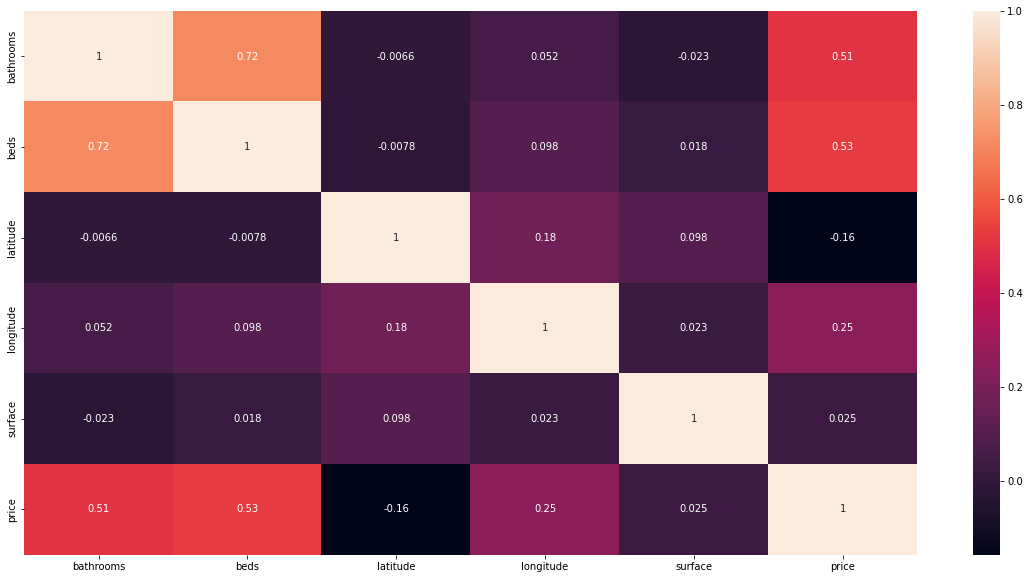

In [31]:
sns.heatmap(df_train.corr(), annot = True)

The most influential explanatory variables are **beds**, **bathrooms** followed at a distance by **longitude** and **latitude**.

### Load Test Data Set

In [32]:
# load test dataset
df_test = pd.read_csv(testing_file)

In [33]:
# show first data frame rows of the test df
df_test.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


We repeat removal of features we have removed from the train dataset.

In [34]:
df_test.drop(['description_block', 'features', 'facility', 'no_of_units', 'ad_id'], axis=1, inplace=True)

In [35]:
df_test.isna().sum()

area                   0
bathrooms              0
beds                   0
ber_classification    56
county                 0
environment            0
latitude               0
longitude              0
property_category      0
property_type          0
surface                0
dtype: int64

In [36]:
# Generate descriptive statistics
df_test.describe()

,bathrooms,beds,latitude,longitude,surface
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.994000,2.930000,53.356034,-6.247842,156.007671
std,1.106532,1.191612,0.081905,0.088552,344.497362
min,0.000000,0.000000,53.221348,-6.496987,33.500000
25%,1.000000,2.000000,53.297373,-6.296404,72.375000
50%,2.000000,3.000000,53.339547,-6.243572,98.000000
75%,3.000000,4.000000,53.381650,-6.185055,138.935000
max,8.000000,7.000000,53.619775,-6.064874,5746.536120


### Expected Cost dataset

In [37]:
# load train dataset
df_cost = pd.read_csv(cost_file)

# show first data frame rows
df_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [38]:
# Generate descriptive statistics
df_cost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


In [39]:
df_cost.isna().sum()

Id          0
Expected    0
dtype: int64

In [40]:
# show data set shape
df_train.shape

(2929, 12)

In [41]:
# show data set shape
df_test.shape

(500, 11)

In [42]:
# show data set shape
df_cost.shape

(500, 2)

In [43]:
# X_train is from train data set except column price
X_train = df_train.loc[:, df_train.columns != 'price']

# X_test is from test data set
X_test = df_test

# y_train is form train data set with column price
y_train = df_train[['price']]

# y_test is from true price with column Expected
y_test =  df_cost[['Expected']]

In [44]:
X_train

,area,bathrooms,beds,ber_classification,county,environment,latitude,longitude,property_category,property_type,surface
15,Clonee,3.0,5.0,A3,Dublin,prod,53.400454,-6.445730,new_development_parent,detached,321.0
26,Clondalkin,4.0,4.0,A3,Dublin,prod,53.316410,-6.385214,new_development_parent,semi-detached,144.0
27,Clonee,3.0,5.0,A3,Dublin,prod,53.401414,-6.446634,new_development_parent,detached,321.0
35,Howth,5.0,5.0,A2,Dublin,prod,53.375377,-6.056749,new_development_parent,detached,312.0
38,Castleknock,2.0,2.0,A3,Dublin,prod,53.372130,-6.338466,new_development_parent,apartment,83.0
...,...,...,...,...,...,...,...,...,...,...,...
2977,Ballsbridge,2.0,2.0,C3,Dublin,prod,53.338738,-6.237199,sale,apartment,56.0
2978,Rialto,1.0,3.0,B2,Dublin,prod,53.335793,-6.294268,sale,terraced,101.0
2979,Smithfield,1.0,2.0,C3,Dublin,prod,53.346098,-6.276856,sale,apartment,55.6
2980,Foxrock,2.0,3.0,C3,Dublin,prod,53.273518,-6.178500,sale,end-of-terrace,97.0


In [45]:
X_test

,area,bathrooms,beds,ber_classification,county,environment,latitude,longitude,property_category,property_type,surface
0,Skerries,2.0,4.0,G,Dublin,prod,53.566881,-6.101148,sale,bungalow,142.0
1,Lucan,2.0,3.0,C1,Dublin,prod,53.362992,-6.452909,sale,terraced,114.0
2,Swords,3.0,4.0,B3,Dublin,prod,53.454198,-6.262964,sale,semi-detached,172.0
3,Lucan,4.0,3.0,A3,Dublin,prod,53.354402,-6.458647,sale,semi-detached,132.4
4,Clondalkin,1.0,3.0,E2,Dublin,prod,53.336530,-6.393587,sale,semi-detached,88.0
...,...,...,...,...,...,...,...,...,...,...,...
495,Ringsend,1.0,2.0,NaN,Dublin,prod,53.342207,-6.226101,sale,apartment,65.0
496,Cabinteely,3.0,5.0,E1,Dublin,prod,53.261475,-6.147720,sale,detached,191.3
497,Artane,1.0,3.0,G,Dublin,prod,53.391619,-6.205157,sale,detached,105.0
498,Clontarf,2.0,4.0,E2,Dublin,prod,53.360578,-6.183701,sale,end-of-terrace,130.0


In [46]:
y_train

,price
15,935000.0
26,485000.0
27,935000.0
35,1475000.0
38,410000.0
...,...
2977,415000.0
2978,485000.0
2979,299000.0
2980,495000.0


In [47]:
y_test

,Expected
0,875000.0
1,355000.0
2,440000.0
3,425000.0
4,265000.0
...,...
495,345000.0
496,775000.0
497,360000.0
498,925000.0


# PIECEWISE REGRESSION

## Full Model

In [48]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['beds', 'latitude', 'longitude', 'surface','price']
# dropna: remove missing values
df_subset_train = df_train[featrain].dropna(axis=0)

featest = ['beds', 'latitude', 'longitude', 'surface']
df_subset_test  =  df_test[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [49]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


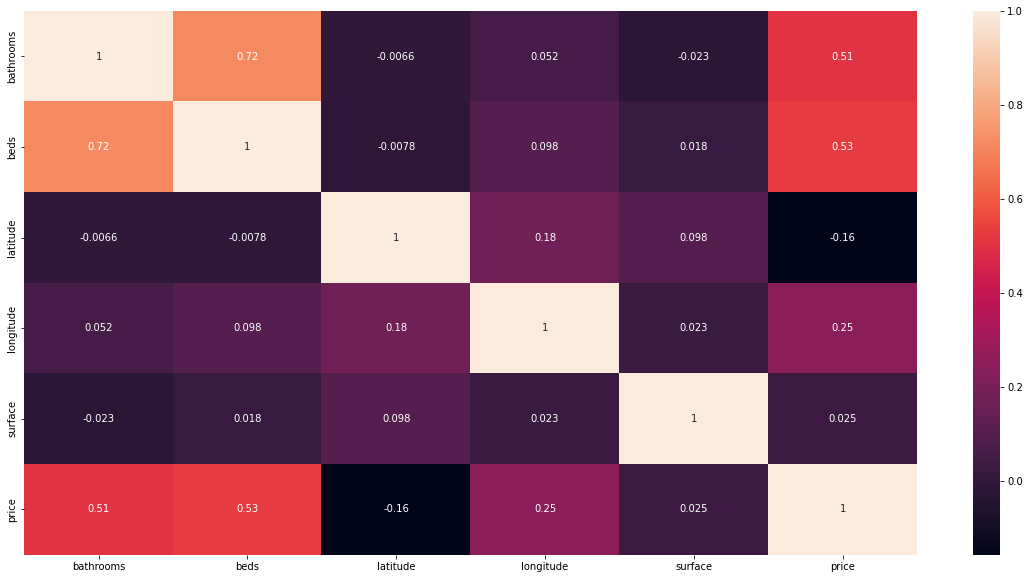

In [50]:
sns.heatmap(df_train.corr(), annot = True)

It can be seen that **beds** and **bathrooms** are most strongly correlated with **price** having positive correlation. The features **longitude** and to a lesser extent **latitude** are also correlated with **latitude** being the only feature to have a negative correlation to price.  
  
The correlation of **latitude** and **longitude** with price is not surprising as a well known mantra within the real estate profession is "location, location, location". The implication with this correlation is that a north-south and east-west divide exists in relation to house pricing in Dublin.  

Our heatmap shows that the features in order of importance are **beds**, **bathrooms**, **longitude** and **latitude**.

---
We now define helper functions:

In [51]:
def generate_bayesian_lin_reg_model(
    alpha: dict={'mu':0, 'sigma':30},
    beta: dict={'mu':0, 'sigma':30},
    sigma: dict={'beta':5},
    iteration_cnt: int=40000,
    sample_cnt: int=5000,
    X: np.ndarray=None,
    y: np.ndarray=None
    ):
    """Generate a Bayesian linear regression model
    
    alpha, beta defined as normal distributions
    sigma defined as HalfCauchy distribution
    
    Args:
        alpha: dict containing mu and sigma values for alpha normal distribution
        beta: dict containing mu and sigma values for beta normal distribution
        sigma: dict containing sigma value for sigma HalfCauchy distribution
        iteration_cnt: int iteration count for bayesian linear reg. model fit
        sample_cnt: int sample count drawn from posterior
        X: np.ndarray of training data
        y: np.ndarray of labels

    Returns:
        Approximation for the model
        Posterior for the bayesian linear regression model
    """
    with pm.Model() as model:
        # prior over the parameters of linear regression
        _alpha = pm.Normal('alpha', mu=alpha['mu'], sigma=alpha['sigma'])
        # we have a beta for each column of Xn
        _beta = pm.Normal('beta', mu=beta['mu'], sigma=beta['sigma'], shape=X.shape[1])
        # prior over the variance of the noise
        _sigma = pm.HalfCauchy('sigma_n', beta=sigma['beta'])
        # linear regression relationship
        #linear regression model in matrix form
        _mu = _alpha + pm.math.dot(_beta, X.T)
        # likelihood 
        like = pm.Normal('like', mu=_mu, sigma=_sigma, observed=y[:,0])
  
    with model:
        # iterations of the algorithm
        approximation = pm.fit(iteration_cnt, method='advi')

    # samples from the posterior    
    posterior = approximation.sample(sample_cnt)
    return posterior, approximation

In [52]:
def blr(
    posterior,
    yscaler,
    test,
    ):
    """Calculate BLR value
    
    Args:
        posterior: pymc3 MultiTrace, sampled data from posterior belief
        yscaler: StandardScaler
        test: np.ndarray, test data

    Return:
        BLR value
    """
    y_pred_blr = np.exp(yscaler.inverse_transform(np.mean(posterior['alpha']) 
              + np.dot(np.mean(posterior['beta'],axis=0), test.T)))
    return y_pred_blr

def mae(
    y_pred_blr,
    y_test
    ):
    """Calculate MAE value
    
    Args:
        y_pred_blr: blr value
        y_test: y values of test set
    Return:
        MAE value
    """
    mae = np.mean(abs(y_pred_blr - y_test))
    return mae

def mape(
    y_pred_blr,
    y_test
    ):
    """Calculate MAPE value
    
    Args:
        y_pred_blr: blr value
        y_test: y values of test set
    Return:
        MAPE value
    """
    mape = np.mean(abs(y_pred_blr - y_test) / y_test)
    return mape

In [53]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost['Expected'].values

In [54]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 2,538.3


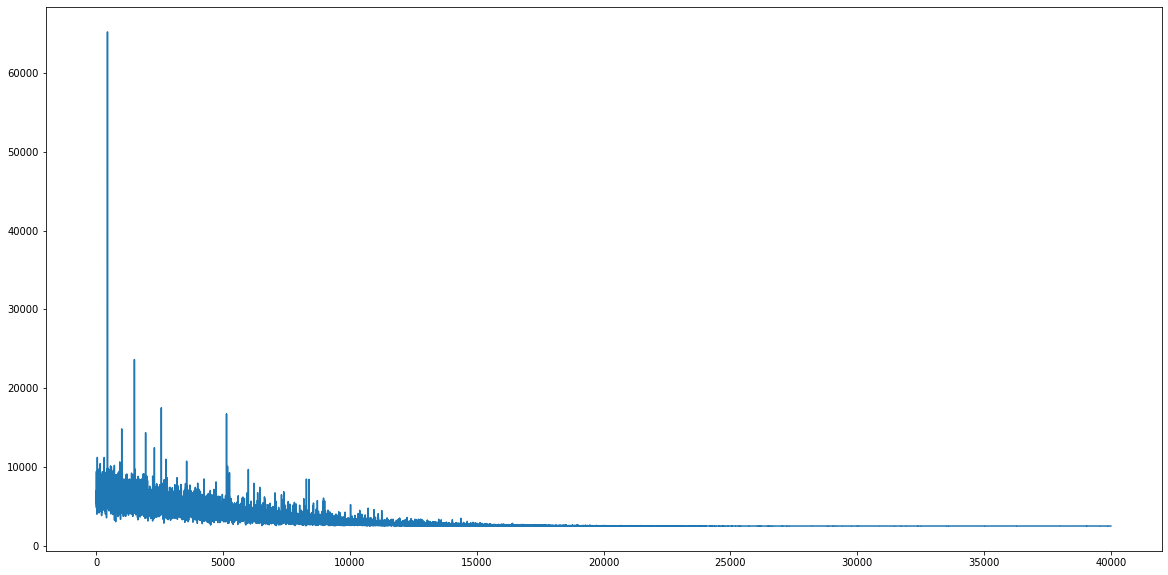

In [55]:
posterior, approximation = generate_bayesian_lin_reg_model(X=Xn_train, y=yn_train)

# check the convergence
plt.plot(approximation.hist);

In [56]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]

full_model_mae = mae(y_pred_BLR, y_test)
full_model_mape = mape(y_pred_BLR, y_test)
print(f"MAE: {full_model_mae:.0f}, MAPE: {full_model_mape:.4f}")

MAE: 212361, MAPE: 0.2814


###  MAE and MAPE, what are they and why we use them. 

We use a loss function to determine how accurately our model can predict the expected outcome. High values for loss implies the model is performing poorly and conversely low values means the model is performing well. Loss functions have pros and cons. We will use MAE and MAPE when reviewing performance of our models in this e-tivity. The MAE score has the advantage that all values are will be weighted on a linear scale as the absolute value is taken (Seif, G, 2019). Outliers will not have an undue effect in comparison to Mean Squared Error (MSE).
  
- MAE (Statistics How To, 2021)
"The Mean Absolute Error(MAE) is the average of all absolute errors."  
  
- MAPE (Statistics How To, 2021)
"The mean absolute percentage error (MAPE) is a measure of how accurate a forecast system is. It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values."

## Clustering

To determine how many clusters to use we analyze different k values for k-means clustering and look for a knee in the resultant graph.  
We'll also use the silhouette scoring (Rousseeuw, P. J.) for added information in determing the correct number of clusters to use.  

In [57]:
inertia = []
for k in range(1,15):
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=20, max_iter=500, random_state=10).fit(Xn_train)
    inertia.append(clustered_data_sklearn.inertia_)

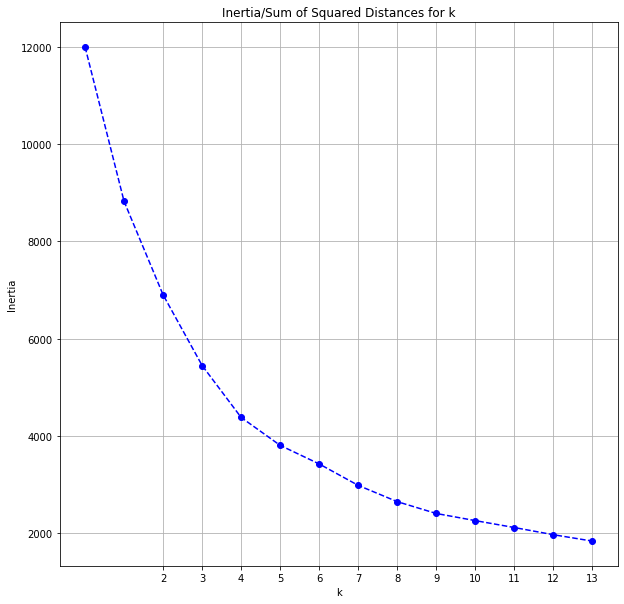

In [58]:
plt.figure(figsize=(10,10))
plt.title('Inertia/Sum of Squared Distances for k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(range(2, 30))
plt.grid()
plt.plot(inertia, linestyle='--', marker='o', color='b')

In [59]:
# As per website: https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters 
silhouette_coefficients = []
   
# Start at 2 clusters for silhouette coefficient
for k in range(2, 15):
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=20, max_iter=500, random_state=10).fit(Xn_train)
    score = silhouette_score(Xn_train, clustered_data_sklearn.labels_)
    silhouette_coefficients.append(score)

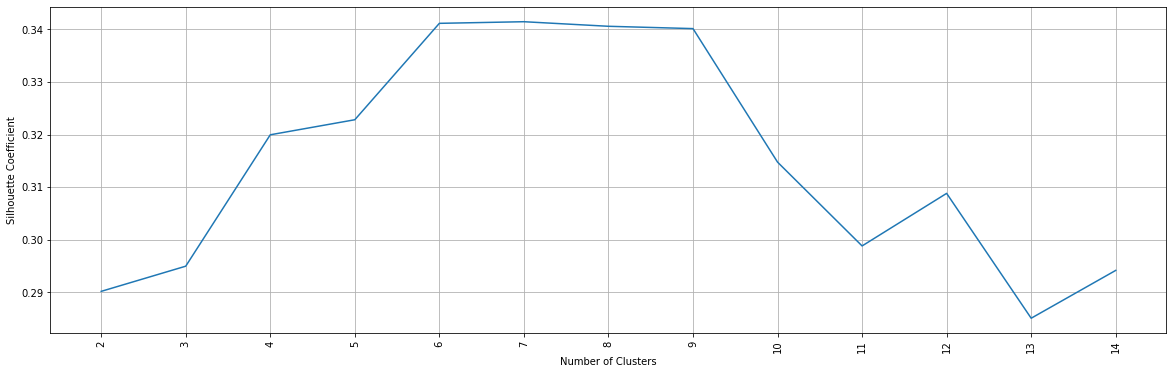

In [60]:
plt.figure(figsize=(20,6))
plt.plot(range(2,15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xticks(rotation=90)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.grid()
plt.show() 

In reviewing k-means for different number of clusters we see a knee point of 4 or 5. This implies we should use 5 clusters.  

With the silhouette score (Rousseeuw, P. J.) we look for the maximum value and at which number of clusters it occurs. Here we see a maximum value occuring at 7 clusters.  
  
The silhouette method scoring function uses inter-cluster and intra-cluster distances. The elbow method only uses intra-cluster distances. This can explain the difference in suggested cluster number between the two methods.  

Ultimately it is on us to interpret the graphs. We will try 5 clusters given our results from elbow and silhouette methods.

### Full Model

We will trial clustering by GMM using discrete and continuous features (Solanki, G.). Previously we saw the features in order of importance were **beds**, **bathrooms**, **longitude** and **latitude**.  
**beds** and **bathrooms** are discrete numbered features whereas **longitude** and **latitude** are continuous.

Text(0.5, 1.0, 'GMM clustering by "beds" and "latitude", 5 x clusters')

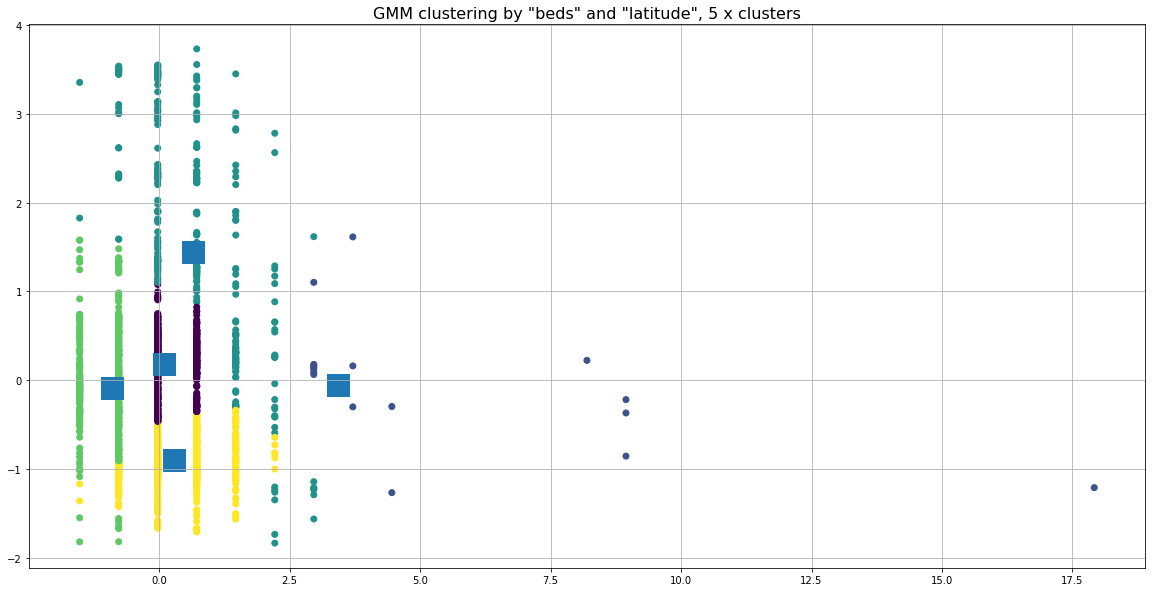

In [61]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)

# featest = ['beds', 'latitude', 'longitude', 'surface']
# clustering by features beds, latitude 
ind=[0,1]
#X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Using train data only for gmm fit
X_ind = Xn_train[:,ind]

# Gaussian Mixture
gmm.fit(X_ind)
plt.grid()

# Predict the training data so we can label the dots
labels = gmm.predict(X_ind)
plt.scatter(X_ind[:,0],X_ind[:,1], c=labels)

# centroids
plt.scatter(gmm.means_[:,0],gmm.means_[:,1], marker="s", s=22**2)
plt.title('GMM clustering by "beds" and "latitude", 5 x clusters', fontsize=16)

We now trial clustering on continuous data. We choose **longitude** and **latitude** of our list of most influential variables.

Text(0.5, 1.0, 'GMM clustering by "latitude" and "longitude", 5 x clusters')

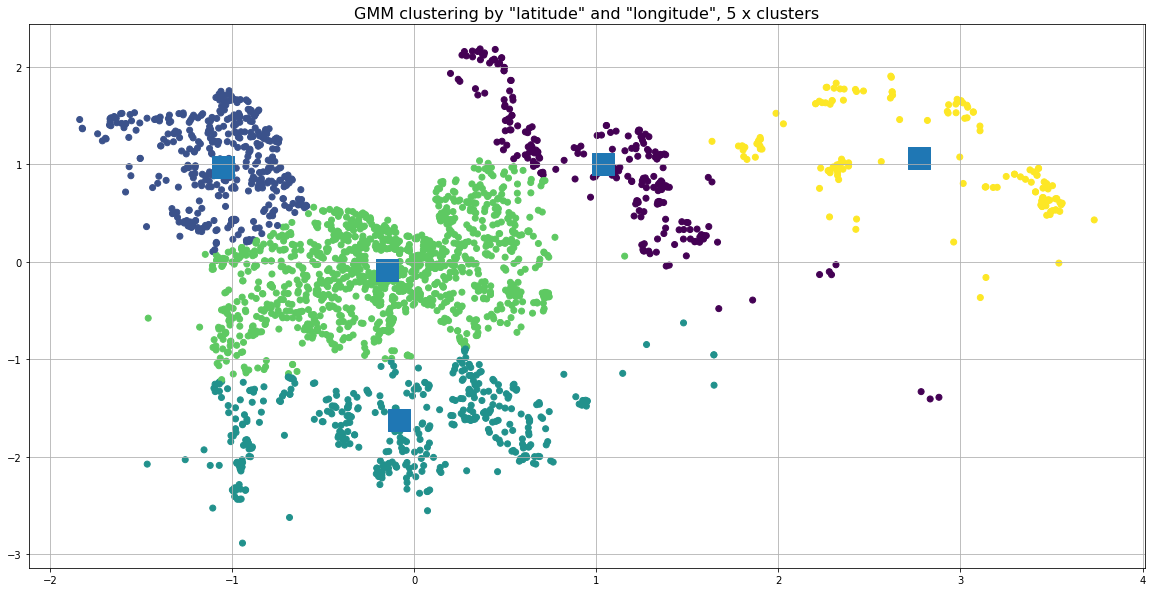

In [62]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)

# featest = ['beds', 'latitude', 'longitude', 'surface']
# clustering by features latitude and longitude 
ind=[1,2]
# stacking train and test data for gmm fit:
#X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Using train data only for gmm fit
X_ind = Xn_train[:,ind]

# Gaussian Mixture
gmm.fit(X_ind)
plt.grid()

# Predict the training data so we can label the dots
labels = gmm.predict(X_ind)
plt.scatter(X_ind[:,0],X_ind[:,1], c=labels)

# centroids
plt.scatter(gmm.means_[:,0],gmm.means_[:,1], marker="s", s=22**2)
plt.title('GMM clustering by "latitude" and "longitude", 5 x clusters', fontsize=16)

We believe there is more opportunity for the data to cluster correctly when it has the freedom afforded by continous variables rather than the binning of discrete variables. For this reason we continue with **latitude** and **longitude**.

In [63]:
np.max(ys_train)

9995000.0

### Clusters

In [64]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 230, 1: 390, 2: 406, 3: 1230, 4: 145}

In [65]:
len(Xn_test)

500

In [66]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 40, 1: 84, 2: 62, 3: 270, 4: 44}

In [67]:
len(clusters_train)

2401

## Piecewise Model

In [68]:
def prep_cluster_data(
    train_data: np.ndarray=None,
    test_data: np.ndarray=None,
    label_data: np.ndarray=None,
    clusters_train_labels: np.ndarray=None,
    clusters_test_labels: np.ndarray=None,
    idx: int=0
    ):
    """Return cluster specific training and test data from all clustered data.
       The training data has already been clustered and we wish to separate it
       into training data specific to a single cluster as defined by 'idx'
    
    Args:
        train_data: np.ndarray containing all clustered training data
        test_data: np.ndarray containing all clustered test data
        label_data: np.ndarray containing all label data
        clusters_train_labels: np.ndarray containing all cluster train labels (data belonging to which cluster)
        clusters_test_labels: np.ndarray containing all cluster tsst labels (data belonging to which cluster)
        idx: int index of which cluster to return
    Returns:
        np.ndarray: cluster specific training data
        np.ndarray: cluster specific test data
        np.ndarray: log of label data specific to cluster
        StandardScaler: scaler for label data
        np.ndarray: transformed log of label data
    """
    Xn = train_data[clusters_train_labels==idx,:]
    Xtestn = test_data[clusters_test_labels==idx,:]
    ylog = np.log(label_data.astype('float')[clusters_train_labels==idx,:])
    yscaler = StandardScaler().fit(ylog)
    yn = yscaler.transform(ylog)
    
    return Xn, Xtestn, ylog, yscaler, yn

In [69]:
Xn0, Xtestn0, ylog0, yscaler0, yn0 = prep_cluster_data(
    Xn_train, Xn_test, ys_train, clusters_train, clusters_test, 0)

In [70]:
Xn1, Xtestn1, ylog1, yscaler1, yn1 = prep_cluster_data(
    Xn_train, Xn_test, ys_train, clusters_train, clusters_test, 1)

In [71]:
Xn2, Xtestn2, ylog2, yscaler2, yn2 = prep_cluster_data(
    Xn_train, Xn_test, ys_train, clusters_train, clusters_test, 2)

In [72]:
Xn3, Xtestn3, ylog3, yscaler3, yn3 = prep_cluster_data(
    Xn_train, Xn_test, ys_train, clusters_train, clusters_test, 3)

In [73]:
Xn4, Xtestn4, ylog4, yscaler4, yn4 = prep_cluster_data(
    Xn_train, Xn_test, ys_train, clusters_train, clusters_test, 4)

In [74]:
posterior0, _ = generate_bayesian_lin_reg_model(X=Xn0, y=yn0)

Finished [100%]: Average Loss = 237.68


In [75]:
posterior1, _ = generate_bayesian_lin_reg_model(X=Xn1, y=yn1)

Finished [100%]: Average Loss = 475.31


In [76]:
posterior2, _ = generate_bayesian_lin_reg_model(X=Xn2, y=yn2)

Finished [100%]: Average Loss = 424.42


In [77]:
posterior3, _ = generate_bayesian_lin_reg_model(X=Xn3, y=yn3)

Finished [100%]: Average Loss = 1,287.8


In [78]:
posterior4, _ = generate_bayesian_lin_reg_model(X=Xn4, y=yn4)

Finished [100%]: Average Loss = 198.82


In [79]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

## Simulations

In [80]:
def model_predict(
    posterior,
    X,
    nsamples,
    yscaler
    ):
    """Generate model predictions
    
    Args:
        posterior: pymc3 MultiTrace, sampled data from posterior belief
        X: np.ndarray, training data
        nsamples: int, number of samples to select from posterior
        yscaler: StandardScaler
    Return:
        Preditions
    """
    Ypred = yscaler.inverse_transform(ppc(posterior['alpha'], posterior['beta'], posterior['sigma_n'],
                                          X, nsamples=nsamples))
    return Ypred
    
def plot_model_pred_vs_observations(
    predictions=None,
    log_labels=None,
    title=None
    ):
    """Plot the model predictions against the actual observations
    
    Args:
        predictions: np.ndarray, model predictions
        log_labels: np.ndarray, log of y labels
    Return:
        None
    
    """
    for i in range(predictions.shape[0]):
        az.plot_dist(predictions[i,:], color='r', plot_kwargs={"linewidth": 0.2})
    az.plot_dist(predictions[i,:], color='r', plot_kwargs={"linewidth": 0.2}, label="prediction")
    az.plot_dist(log_labels, label='true observations');
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot")
    plt.title(title, fontsize=20)

### Only Cluster 0

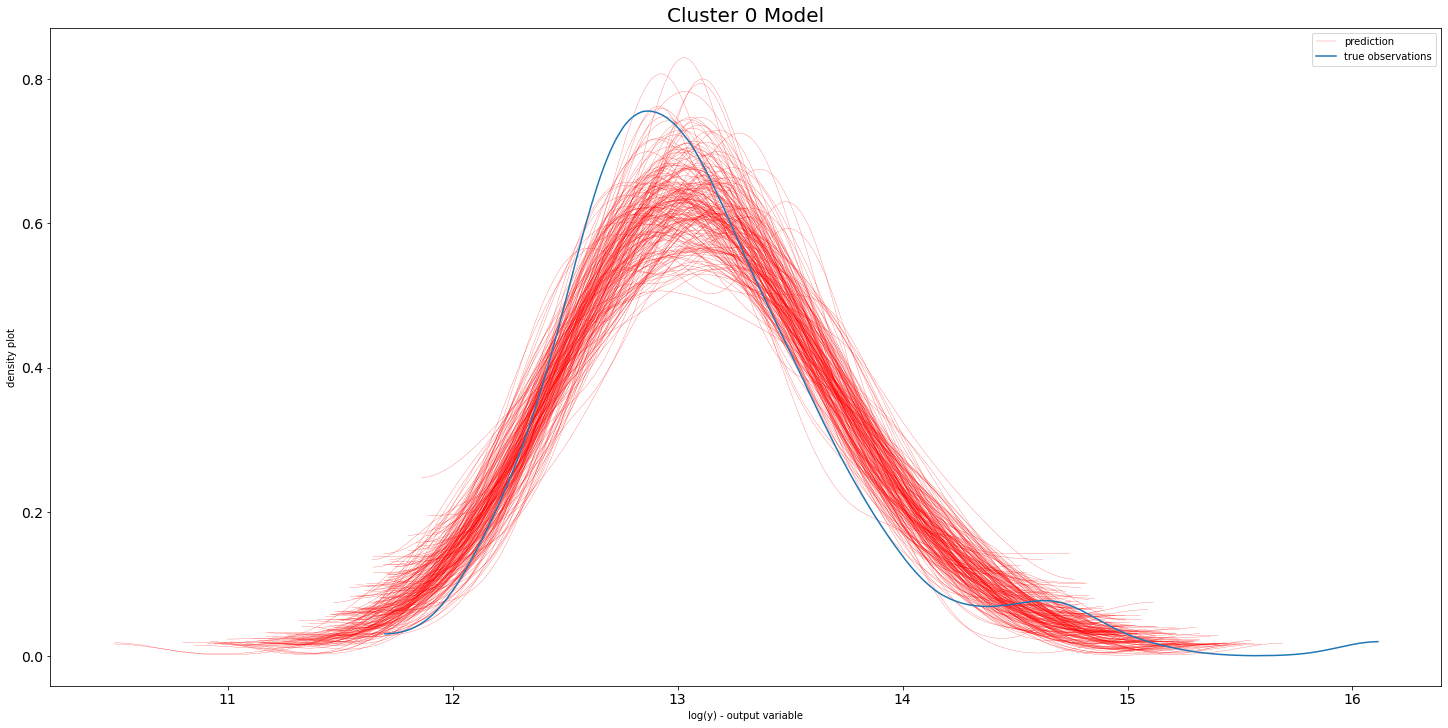

In [81]:
Ypred0 = model_predict(posterior0, Xn0, 200, yscaler0)
plot_model_pred_vs_observations(Ypred0, ylog0, "Cluster 0 Model")

### Only Cluster 1

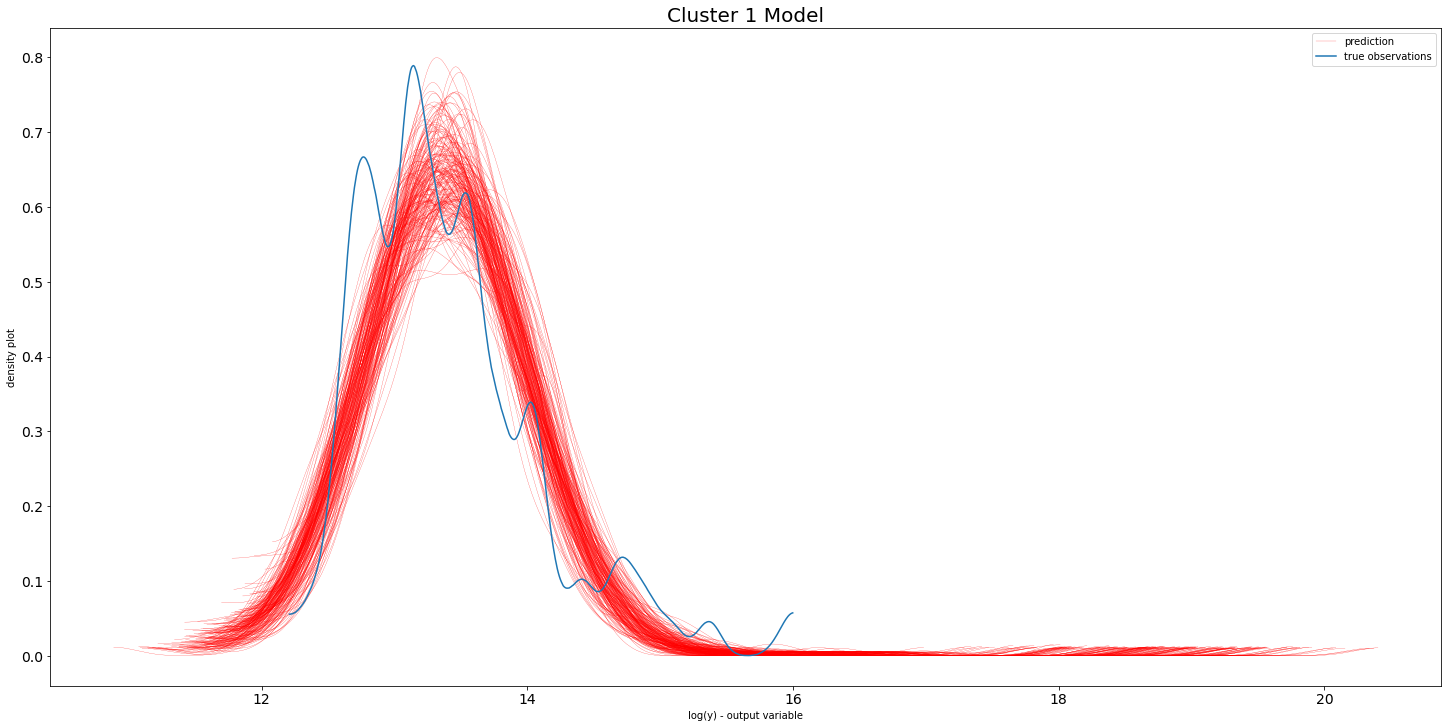

In [82]:
Ypred1 = model_predict(posterior1, Xn1, 200, yscaler1)
plot_model_pred_vs_observations(Ypred1, ylog1, "Cluster 1 Model")

### Only Cluster 2

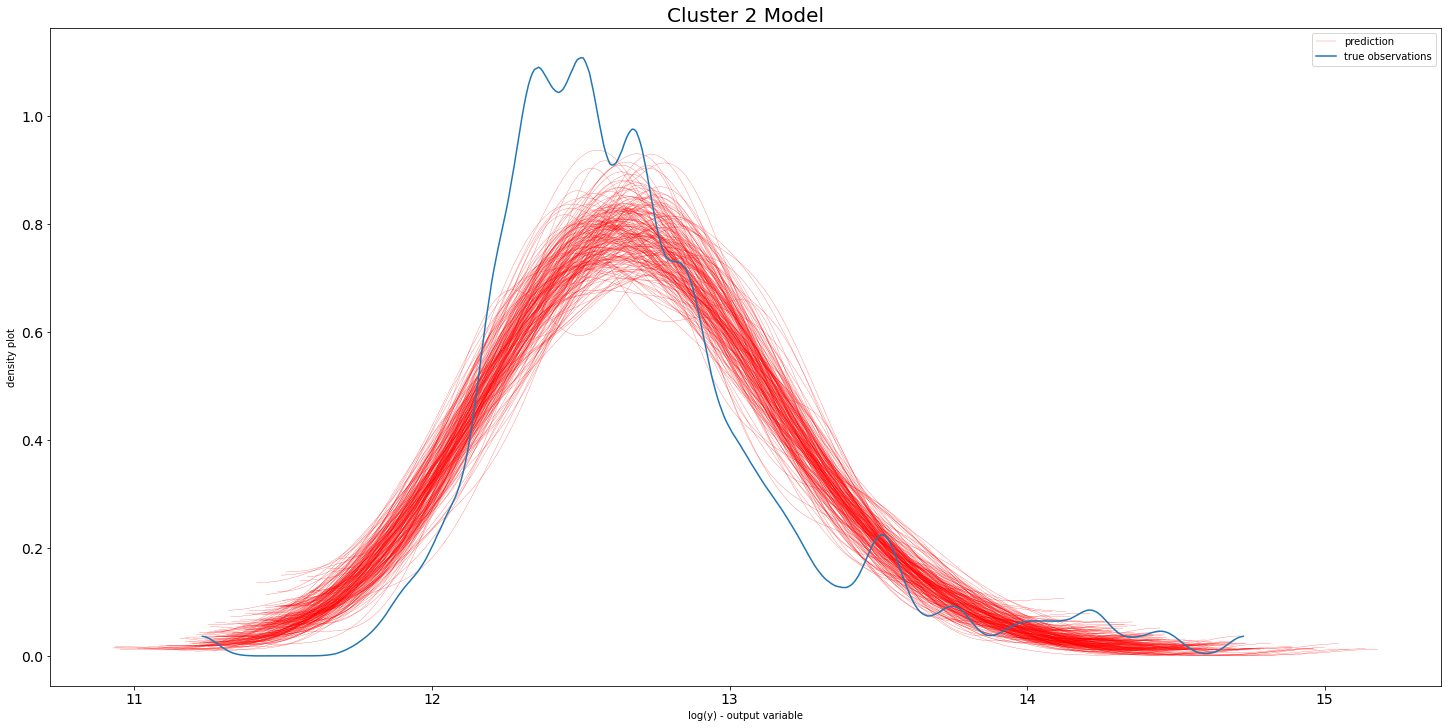

In [83]:
Ypred2 = model_predict(posterior2, Xn2, 200, yscaler2)
plot_model_pred_vs_observations(Ypred2, ylog2, "Cluster 2 Model")

### Only Cluster 3

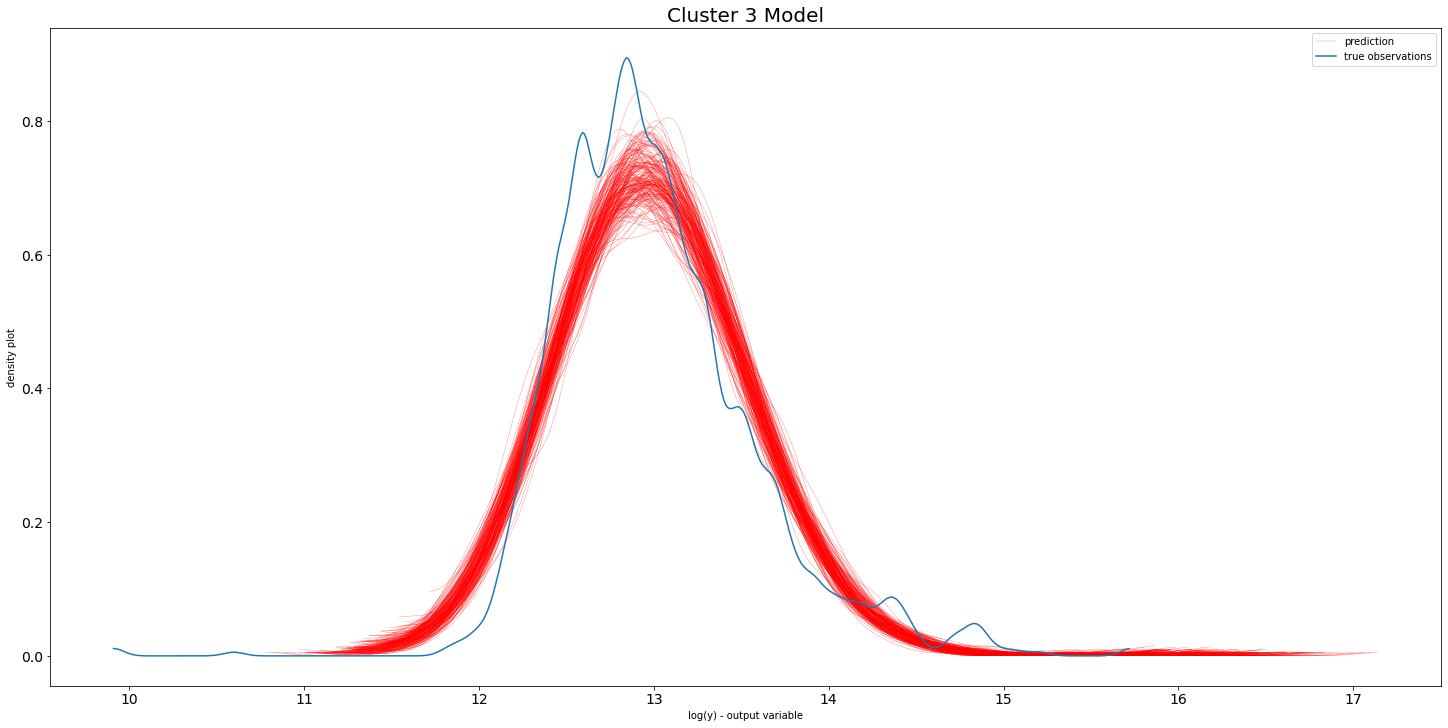

In [84]:
Ypred3 = model_predict(posterior3, Xn3, 200, yscaler3)
plot_model_pred_vs_observations(Ypred3, ylog3, "Cluster 3 Model")

### Only Cluster 4

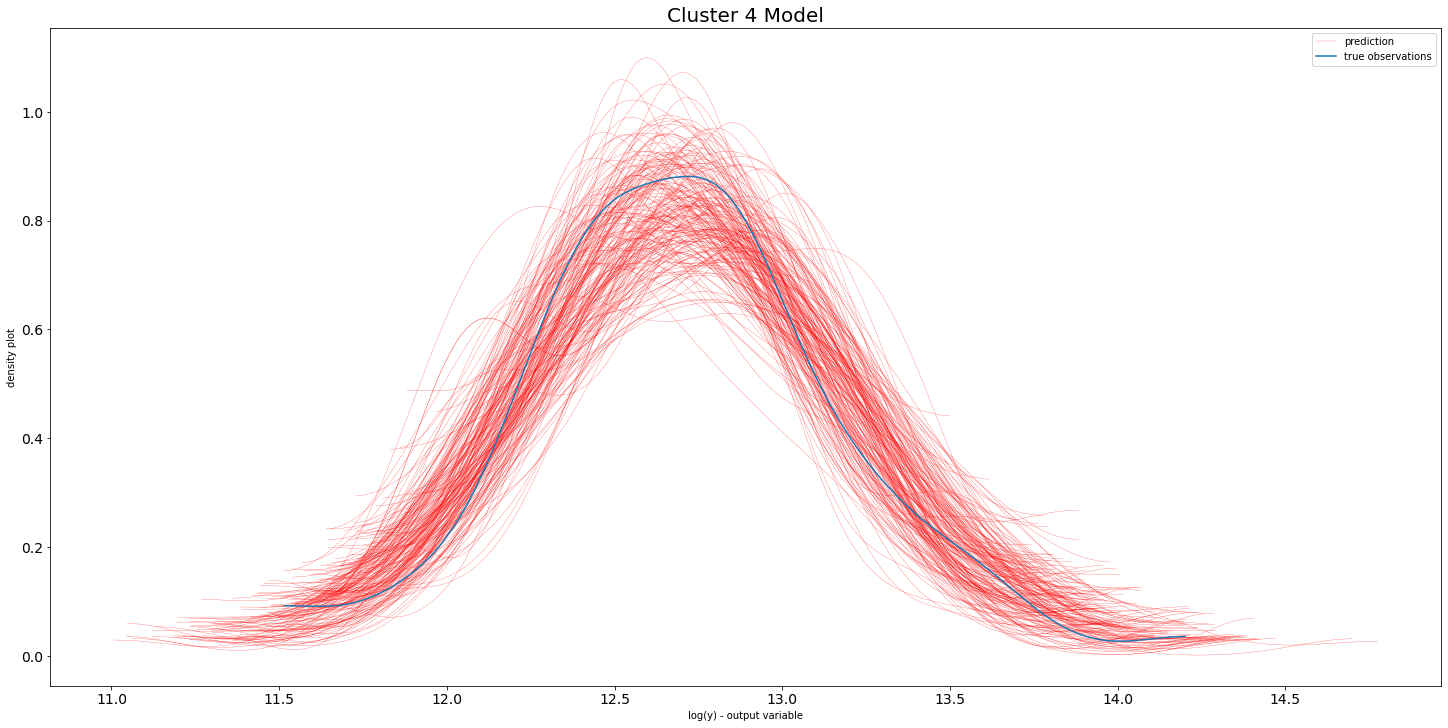

In [85]:
Ypred4 = model_predict(posterior4, Xn4, 200, yscaler4)
plot_model_pred_vs_observations(Ypred4, ylog4, "Cluster 4 Model")

## Overall

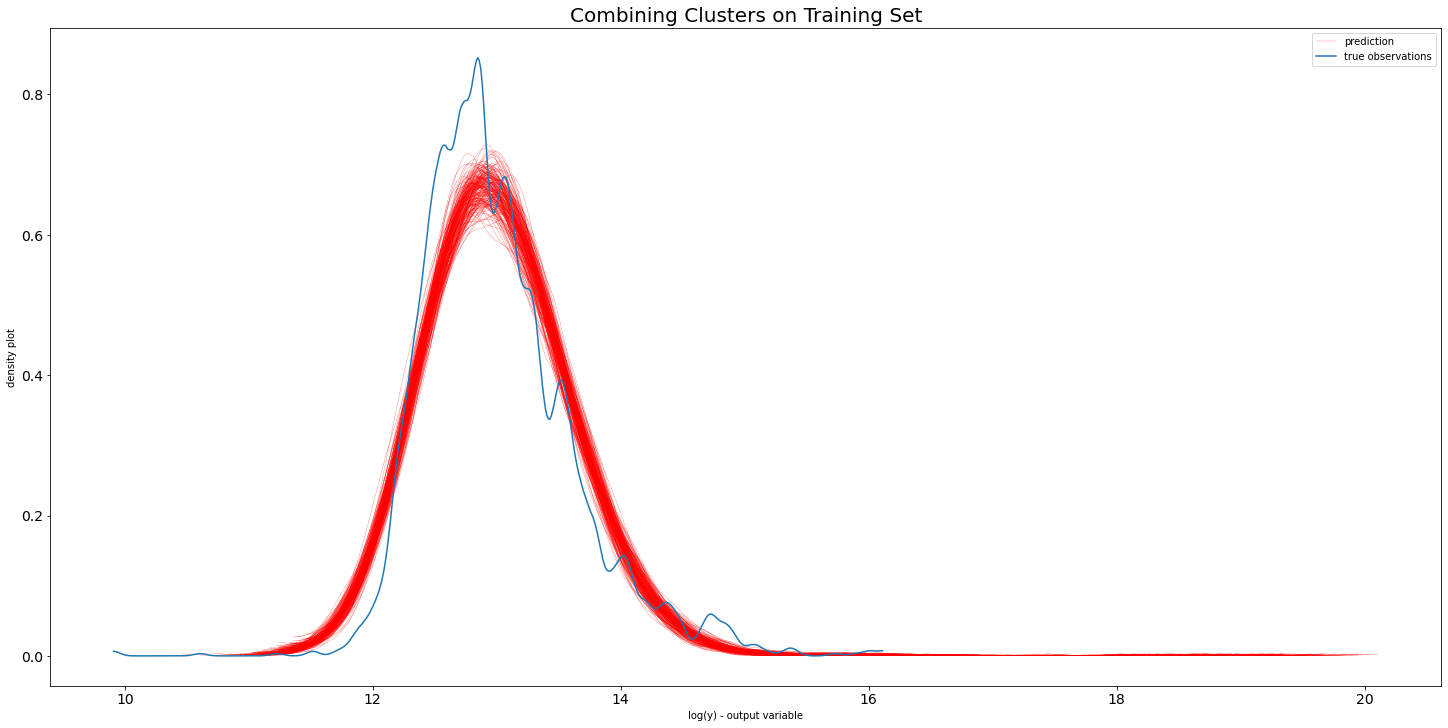

In [86]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4)])
ylog=np.vstack([ylog0, ylog1, ylog2, ylog3, ylog4])

plot_model_pred_vs_observations(Ypred, ylog, "Combining Clusters on Training Set")

## Test set performance

In [87]:
# cluster 0
y_pred_BLR0 = blr(posterior0, yscaler0, Xtestn0)
mae_ = mae(y_pred_BLR0, y_test[clusters_test==0])
mape_ = mape(y_pred_BLR0, y_test[clusters_test==0])
print(f"Size Cluster0: {np.sum(clusters_test==0)},\tMAE: {mae_:.0f}, MAPE: {mape_:.4f}")

# cluster 1
y_pred_BLR1 = blr(posterior1, yscaler1, Xtestn1)
mae_ = mae(y_pred_BLR1, y_test[clusters_test==1])
mape_ = mape(y_pred_BLR1, y_test[clusters_test==1])
print(f"Size Cluster1: {np.sum(clusters_test==1)},\tMAE: {mae_:.0f}, MAPE: {mape_:.4f}")

# cluster 2
y_pred_BLR2 = blr(posterior2, yscaler2, Xtestn2)
mae_ = mae(y_pred_BLR2, y_test[clusters_test==2])
mape_ = mape(y_pred_BLR2, y_test[clusters_test==2])
print(f"Size Cluster2: {np.sum(clusters_test==2)},\tMAE: {mae_:.0f}, MAPE: {mape_:.4f}")

# cluster 3
y_pred_BLR3 = blr(posterior3, yscaler3, Xtestn3)
mae_ = mae(y_pred_BLR3, y_test[clusters_test==3])
mape_ = mape(y_pred_BLR3, y_test[clusters_test==3])
print(f"Size Cluster3: {np.sum(clusters_test==3)},\tMAE: {mae_:.0f}, MAPE: {mape_:.4f}")

# cluster 4
y_pred_BLR4 = blr(posterior4, yscaler4, Xtestn4)
mae_ = mae(y_pred_BLR4, y_test[clusters_test==4])
mape_ = mape(y_pred_BLR4, y_test[clusters_test==4])
print(f"Size Cluster4: {np.sum(clusters_test==4)},\tMAE: {mae_:.0f}, MAPE: {mape_:.4f}")

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3]),
                 abs(y_pred_BLR4 - y_test[clusters_test==4])])

# joint MAPE
joint_MAPE=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]) / y_test[clusters_test==0],
                     abs(y_pred_BLR1 - y_test[clusters_test==1]) / y_test[clusters_test==1],
                     abs(y_pred_BLR2 - y_test[clusters_test==2]) / y_test[clusters_test==2],
                     abs(y_pred_BLR3 - y_test[clusters_test==3]) / y_test[clusters_test==3]])
print(f"Joint MAE:\t{np.mean(joint):.0f}, MAPE: {np.mean(joint_MAPE):.4f}")
print(f"Full model MAE:\t{full_model_mae:.0f}, MAPE: {full_model_mape:.4f}")

Size Cluster0: 40,	MAE: 167359, MAPE: 0.2490
Size Cluster1: 84,	MAE: 265790, MAPE: 0.2638
Size Cluster2: 62,	MAE: 154566, MAPE: 0.2458
Size Cluster3: 270,	MAE: 214232, MAPE: 0.2756
Size Cluster4: 44,	MAE: 84680, MAPE: 0.2132
Joint MAE:	200345, MAPE: 0.2671
Full model MAE:	212361, MAPE: 0.2814


### PPC on the Test set

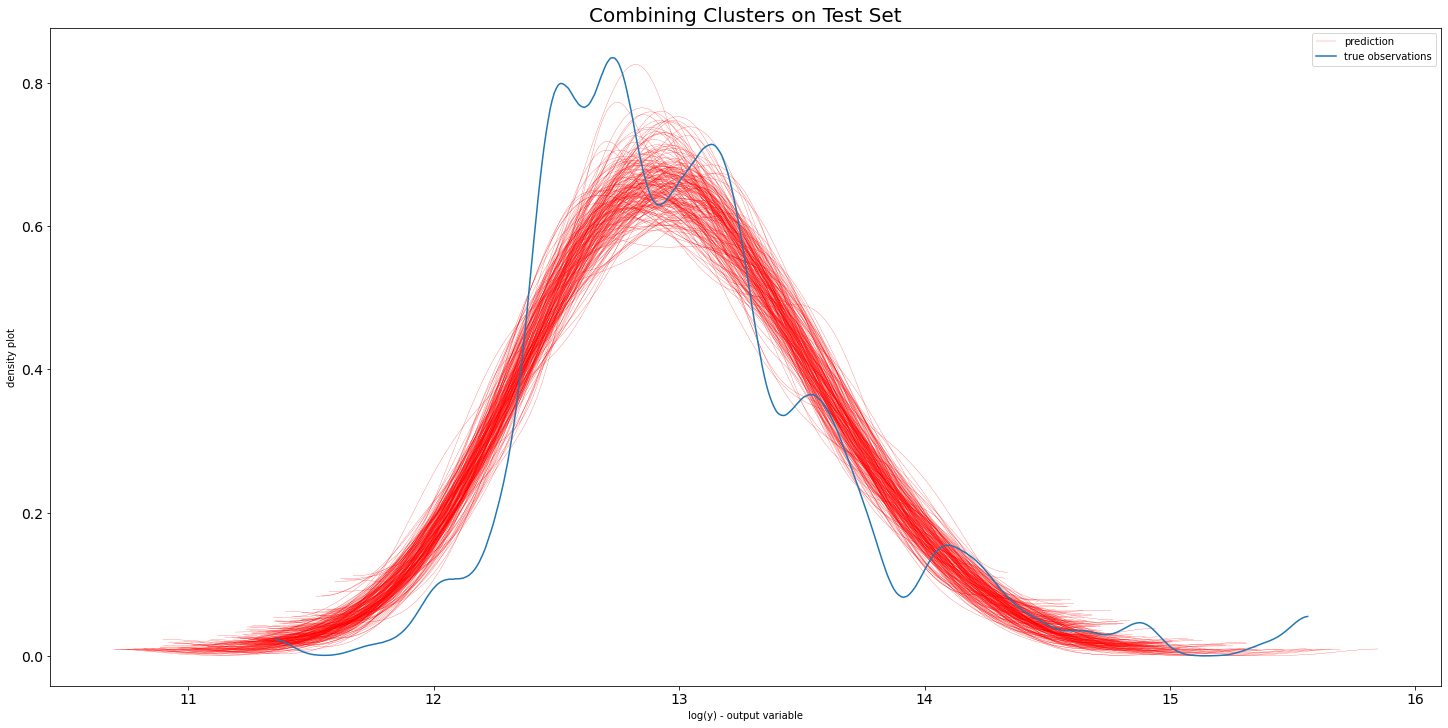

In [88]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xtestn4, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4)])
ylog=np.log(y_test)

plot_model_pred_vs_observations(Ypred, ylog, "Combining Clusters on Test Set")

# SUMMARY

In this etivity the main objective was to perform supervised learning on a house price dataset and contrast a single Bayesian Linear Regression model with a Piecewise Bayesian Linear Regression model.  

The house dataset that we worked through this etivity were compounded by the following features initially, where we performed exploratory data analysis for cleaning the dataset: 

`ad_id`, `area`, `bathrooms`, `beds`, `ber_classification`, `county`,`description_block`, `environment`, `facility`, `features`, `latitude`,`longitude`, `no_of_units`, `property_category`, `property_type`, `surface`, `price`

**Exploratory Data Analysis**

The exploratory data analysis was due to clean some features with invalid or missing values data and outliers were removed from our training dataset as we noticed that missing values for `beds`, `bathrooms` and `property_type` were coincident. With our heatmap, we were able to see a positive linear correlation between the remaining relevant features beds, bathrooms and price, followed by longitude and latitude, although the latitude with a negative correlation.

For the full baseline model, we used `beds`, `latitude`, `longitude`, `surface`, `price` as per the exploratory analysis we found some positive and negative relationships to price.
 
**Fitting the Model**

While using different features scales in our baseline model, we applied feature scaling with StandardScaler in the training dataset to normalize these attributes. When building our basic model, it creates a random variable with Normal prior distributions for the regression coefficients with a mean of 0, standard deviation of 30. We used the mean absolute error (MAE) and mean percentage error (MAPE) metrics to evaluate the performance of model prediction where high values for loss may represent a poor performance.
  
Following data cleaning we trained a Bayesian Linear model on the full training dataset. We calculated the MAE and MAPE scores to allow for later comparison against the piecewise linear models. 

**Clustering**
  
For piecewise linear regression we used multiple models which are trained on a subset of the data. Switchpoints determine when we will use which model. We decide the switchpoints in our case by clustering the training data with a Gaussian Mixture Model (GMM). Subsequent to fitting the GMM on our training data we will be able to predict using the GMM which cluster our test data or new data belongs to. After training each piecewise model on a single cluster of data we have individual models which best represent a cluster of the dataset. The intuition behind piecewise linear models is that the individual models can better represent the data than a single linear model.  
  
We determined through the use of k-means clustering with elbow and silhouette methods that the training data had 5 clusters. Initially the methods showed 4 and 9 clusters for elbow and silhouette methods but after further data cleaning which removed invalid entries, replaced 0 **beds** with the mode and excluded some outliers in the dataset this became 5 and 7. We trialed clustering on discrete variables, **beds**, and also on continuous variables, {**lat**, **long**}, before deciding to use **lat** and **long** as we thought the continous variables would give more granularity to the model to fit the data than the discrete ones. The cluster sizes seemed reasonable although one is a multiple in size compared to the others. 
  
We then trained our Bayesian piecewise linear regression models with each linear regression model represented by the following where $i=[0, 4]$:  
$$y(x) = \alpha_i+\beta_i^T X $$  

**Simulations**

With posterior predictive checks (PPCs) we were able to validate the model predictions by clusters against the actual observations as presented in our plots. We can see in these plots the degree to which predictions models can deviate from data generated from the true observations. In this last simulation the Cluster 2 model followed by Cluster 1 model presented bigger deviation compared to the remaining Clusters. Overall we can observe some prominent deviation in our combining Cluster on the training set, even though our data has been normalized.

**Discussion and Conclusion**

On determining the MAE and MAPE scores for the joint linear model we see that there is approximately a 2% drop in MAPE between the full and piecewise model joint result. The MAE loss score is lower in the piecewise model. These scores show the piecewise model outperforms the single model for this dataset. Meanwhile, based on the performance result we can see the MAE and MAPE result for each cluster are better than the joint result. It proved the house price followed different linear trends over different regions of the data.

| Model        | MAE           | MAPE  |
| :------------- |:-------------:| -----:|
| Full      | 212380 | 0.282 |
| Piecewise Joint      | 200342      |  0.2637 |  
| Piecewise Cluster 0      | 265496      |  0.2618 |  
| Piecewise Cluster 1      | 84487       |  0.2146 |  
| Piecewise Cluster 2      | 214326      |  0.2764 |  
| Piecewise Cluster 3      | 154579      |  0.2455 | 
| Piecewise Cluster 4      | 167491      |  0.2467 |
  
Initially we fit the GMM clustering on both the training and test datasets as per the lab notebook. However we believe this mis-represents the performance of the piecewise linear model as it must include the clustering as a pre-step to determine which of the individual models to use when it is used on out-of-sample data. For completeness the performance seen when the GMM was trained with both training and test data was:

| Model        | MAE           | MAPE  |
| :------------- |:-------------:| -----:|
| Full      | 212380 | 0.282 |
| Piecewise      | 200342      |  0.2637 |
| Piecewise (GMM fit on test and training)      | 199767      |  0.244 |    
  
We believe a better result could probably be attained by doing further data cleaning. Our experience was that both the full and piecewise model losses decreased as we performed further data cleaning and perhaps making better use of the categorical variables. Overall piecewise linear regression is shown to be a useful tool.    

# References

Seif, G. (2019) Understanding the 3 most common loss functions for Machine Learning Regression. Available at https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3 (Accessed: 24 September 2021).

Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55

Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. Journal of Computational and Applied Mathematics, 20(C), 53–65. https://doi.org/10.1016/0377-0427(87)90125-7
  
Solanki, G., 2020. Understanding Gaussian Mixture Model, Available at: https://www.mygreatlearning.com/blog/gaussian-mixture-model/ (Accessed: 28 September 2021).
  
Statistics How To (2021), Mean Absolute Percentage Error (MAPE). Available at https://www.statisticshowto.com/mean-absolute-percentage-error-mape/ (Accessed: 2 October 2021).
  
Statistics How To (2021), Mean Absolute Error (MAE). Available at 
https://www.statisticshowto.com/absolute-error/ (Accessed: 2 October 2021).